### IMPORTATIONS

In [112]:
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import uuid
import matplotlib.pyplot as plt

### DATASET CONSTRUCTION AND PREPROCESSING

##### Path configuration

In [113]:
# Define paths

ANCHORS_PATH = os.path.join("data", "anchors")
NEGATIVES_PATH = os.path.join("data", "negatives")
POSITIVES_PATH = os.path.join("data", "positives")

In [5]:
## Make directories if they're is not exist

if not os.path.exists(ANCHORS_PATH):
    os.makedirs(ANCHORS_PATH)

if not os.path.exists(NEGATIVES_PATH):
    os.makedirs(NEGATIVES_PATH)

if not os.path.exists(POSITIVES_PATH):
    os.makedirs(POSITIVES_PATH)

##### Extract the data from lfw

In [ ]:
! tar -xvzf lfw.tgz

##### Move files from lfw to data/negatives 

In [10]:
for dir in os.listdir("lfw"):
    for image_dir in os.listdir(os.path.join("lfw", dir)):
        old_path = os.path.join(os.path.join("lfw", dir), image_dir)
        os.replace(old_path, os.path.join(NEGATIVES_PATH, image_dir))

##### Collect Anchors & Positives

In [10]:
cam = cv2.VideoCapture(0)
while cam.isOpened():
    _, frame = cam.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow("image collection", frame)

    if cv2.waitKey(1) & 0XFF == ord("p"):
        image_name = "{}.jpg".format(uuid.uuid1())
        cv2.imwrite(os.path.join(POSITIVES_PATH, image_name), frame)

    elif cv2.waitKey(1) & 0XFF == ord("a"):
        image_name = "{}.jpg".format(uuid.uuid1())
        cv2.imwrite(os.path.join(ANCHORS_PATH, image_name), frame)

    elif cv2.waitKey(1) & 0XFF == ord("q"):
        break

cam.release()
cv2.destroyAllWindows()

##### Make a dataset

In [114]:
anchors = tf.data.Dataset.list_files(os.path.join(ANCHORS_PATH,"*.jpg")).take(400)
positives = tf.data.Dataset.list_files(os.path.join(POSITIVES_PATH,"*.jpg")).take(400)
negatives = tf.data.Dataset.list_files(os.path.join(NEGATIVES_PATH,"*.jpg")).take(400)

In [115]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [116]:
## Building a tensorflow dataset

positive = tf.data.Dataset.zip((anchors, positives, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchors)))))
negative = tf.data.Dataset.zip((anchors, negatives, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchors)))))
dataset = positive.concatenate(negative)

In [117]:
def preprocess_data(input, compared, label):
    input_image = preprocess_image(input)
    compared_image = preprocess_image(compared)
    return input_image, compared_image, label

In [118]:
# Prepare the dataloader

dataset = dataset.map(preprocess_data)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

In [119]:
# Training data preparation (70% of the data)
train_dataset = dataset.take(round(len(dataset)*0.7))
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.prefetch(8)

In [136]:
# Testing data preparation (30% of the data)
test_dataset = dataset.skip(round(len(dataset)*0.7))
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)

### MODEL ARCHITECTURE

##### The encoder model

In [181]:
def encoder():
    input = keras.layers.Input(shape=(100,100,3))

    conv1 = keras.layers.Conv2D(64, (10,10), activation="relu")(input)
    pool1 = keras.layers.MaxPooling2D(2)(conv1)

    conv2 = keras.layers.Conv2D(128, (7,7), activation="relu")(pool1)
    pool2 = keras.layers.MaxPooling2D(2)(conv2)

    conv3 = keras.layers.Conv2D(128, (4,4), activation="relu")(pool2)
    pool3 = keras.layers.MaxPooling2D(2)(conv3)

    conv4 = keras.layers.Conv2D(256, (4,4), activation="relu")(pool3)
    flatten = keras.layers.Flatten()(conv4)

    dense = keras.layers.Dense(4096, activation="sigmoid")(flatten)

    return keras.models.Model(inputs=[input], outputs=[dense], name="Encoder")

In [183]:
encoder_model = encoder()
encoder_model.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 39, 39, 128)       401536    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 19, 19, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       2622

##### Make l_1 distance layer class

In [321]:
class L1Dist(keras.layers.Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def call(self, input_encoder, compared_encoder):
        return tf.math.abs(input_encoder - compared_encoder)

##### Siamese Model

In [210]:
def siamese():

    input_image = keras.layers.Input(shape=(100,100,3), name="input_image")

    compare_image = keras.layers.Input(shape=(100,100,3), name="compare_image")

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distance = siamese_layer(encoder_model(input_image), encoder_model(compare_image))

    output = keras.layers.Dense(1, activation="sigmoid")(distance)

    return keras.models.Model(inputs=[input_image, compare_image], outputs=[output], name="siamese")

In [211]:
siamese_model = siamese()
siamese_model.summary()

Model: "siamese"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 compare_image (InputLayer)     [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           (None, 4096)         27426112    ['input_image[0][0]',            
                                                                  'compare_image[0][0]']    

### TRAINING

##### Loss and optimizer

In [217]:
bce_loss = tf.losses.BinaryCrossentropy()
optim = tf.optimizers.Adam(learning_rate=0.0001)

##### Establish a checkpoint rule

In [218]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optim, siamese_model=siamese_model)

##### Training Step

In [257]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = bce_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optim.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

##### Training Loop

In [262]:
losses = []

In [266]:
def train(data, EPOCHS):

    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        total_loss = 0
        
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            total_loss += loss.numpy()
            progbar.update(idx+1)
        
        print('\n Epoch {}/{} Loss : {}'.format(epoch, EPOCHS, total_loss / len(data)))
        losses.append(total_loss/len(data))
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [267]:
## Start training
EPOCHS = 50
train(train_dataset, EPOCHS)

35/35 [==============================] - 114s 3s/step

 Epoch 1/50 Loss : 0.03783444711672408
35/35 [==============================] - 102s 3s/step

 Epoch 2/50 Loss : 0.017098063127403813
35/35 [==============================] - 104s 3s/step

 Epoch 3/50 Loss : 0.01125013724834259
35/35 [==============================] - 99s 3s/step

 Epoch 4/50 Loss : 0.004813928767440042
35/35 [==============================] - 106s 3s/step

 Epoch 5/50 Loss : 0.0046395606328068035
35/35 [==============================] - 114s 3s/step

 Epoch 6/50 Loss : 0.05288344306339111
35/35 [==============================] - 106s 3s/step

 Epoch 7/50 Loss : 0.03012679327013237
35/35 [==============================] - 102s 3s/step

 Epoch 8/50 Loss : 0.020815464834283506
35/35 [==============================] - 116s 3s/step

 Epoch 9/50 Loss : 0.008488680538721382
35/35 [==============================] - 108s 3s/step

 Epoch 10/50 Loss : 0.002260158098527297
35/35 [==============================] - 123s 4s/step

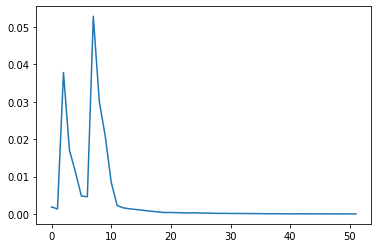

In [268]:
plt.plot(losses)

### EVALUATION

In [290]:
from tensorflow.keras.metrics import Precision, Recall
import numpy as np

In [270]:
input_image, compare_image, label = test_dataset.as_numpy_iterator().next()

In [312]:
def eval(data):
    y_hats = []
    ys = []

    progbar = tf.keras.utils.Progbar(len(data))

    for i, batch in enumerate(data):
        
        X = batch[:2]
        y = batch[2]

        y_hat = siamese_model(X)

        y_hat = np.array([round(x[0]) for x in y_hat.numpy()])
        
        y_hats = np.concatenate((y_hats, y_hat))
        ys = np.concatenate((ys, y.numpy()))

        progbar.update(i+1)
    
    return y_hats, ys

In [313]:
y_hat, y = eval(test_dataset)

15/15 [==============================] - 12s 807ms/step


In [316]:
m = Recall()
m.update_state(y, y_hat)
m.result().numpy()

1.0

In [317]:
m = Precision()
m.update_state(y, y_hat)
m.result().numpy()

1.0

## SAVE & RELOAD THE MODEL

In [318]:
siamese_model.save("siamese_model.h5")

In [322]:
loaded_model = keras.models.load_model("siamese_model.h5", 
                                    custom_objects={"L1Dist" : L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [323]:
loaded_model.predict([input_image, compare_image])

array([[3.3785675e-06],
       [9.7394137e-10],
       [4.9010650e-06],
       [6.2687189e-10],
       [9.9988425e-01],
       [1.0000000e+00],
       [1.8692150e-06],
       [9.9987352e-01],
       [9.9999511e-01],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.3601350e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9994421e-01]], dtype=float32)